In [3]:
import os
os.chdir(os.path.expanduser('~/FFF/'))
import fff
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle as pkl
matplotlib.rcParams.update({'font.size': 20})

INFO: Using pytorch backend


In [158]:
GT = fff.FreeFormInjectiveFlow.load_from_checkpoint(
    "GTs/moons_FIF/checkpoints/last.ckpt"
    )

model = fff.FreeFormFlow.load_from_checkpoint(
    "lightning_logs/m_256_128_1_oclr/version_1/checkpoints/last.ckpt"
)

2moons
cond_dim:  0
latent_dim:  1
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
cond_dim:  1
latent_dim:  2
[3, 256, 256, 3]
[3, 256, 256, 3]
[3, 256, 256, 3]
[3, 256, 256, 3]
[3, 256, 256, 3]
[3, 256, 256, 3]
[3, 256, 256, 3]
[3, 256, 256, 3]
2moons


/export/home/wjoran/miniconda3/envs/py11/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.2.0


cond_dim:  0
latent_dim:  1
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]


In [48]:
torch.set_grad_enabled(False)

10000


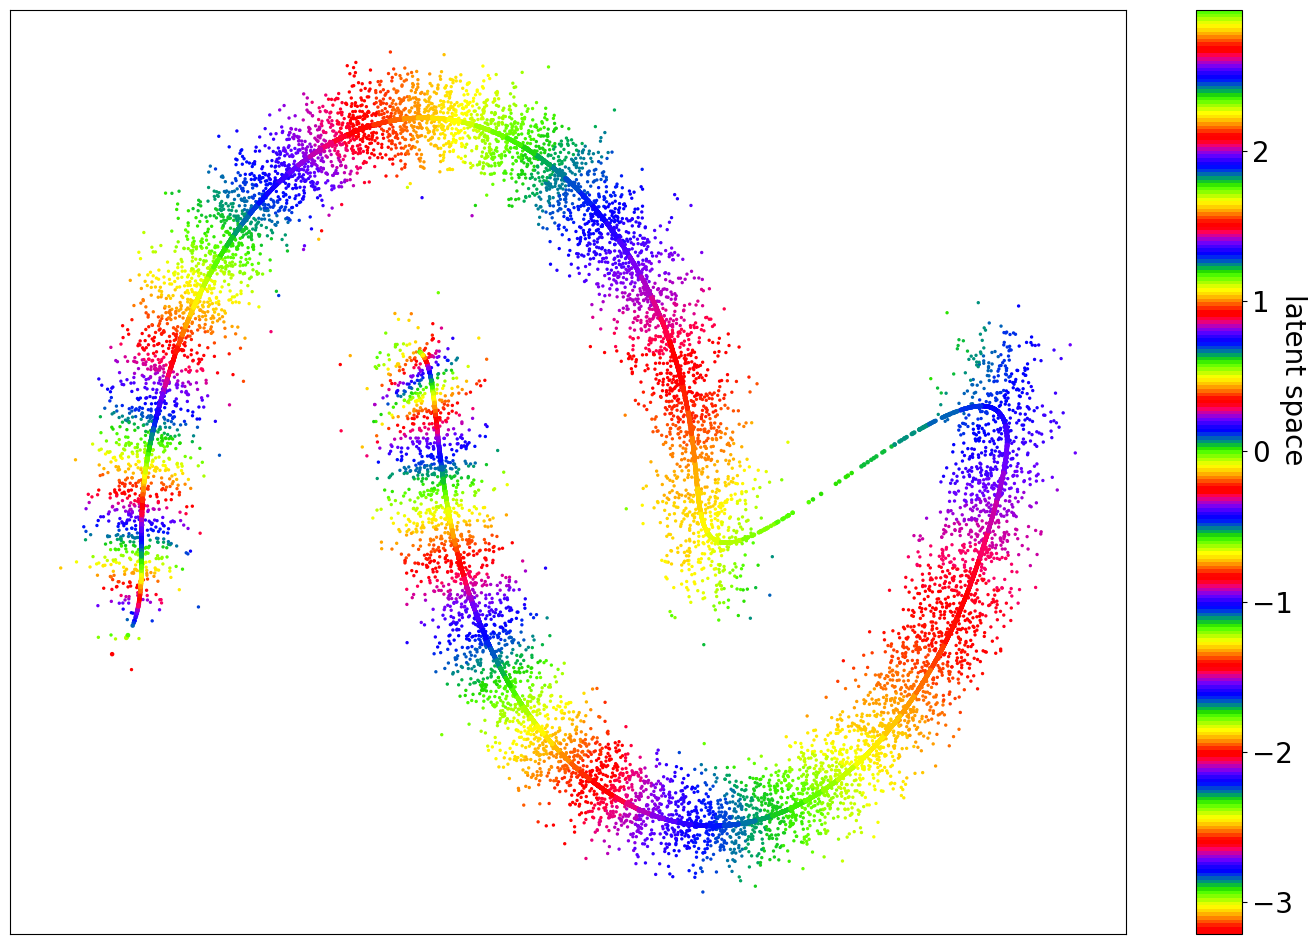

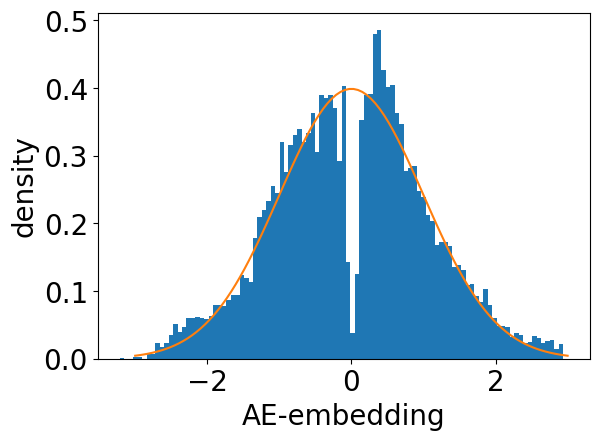

In [34]:
c_targets = plot_manifold(GT.eval())

In [33]:
from fff.evaluate.plots import all_conditions
def plot_manifold(rectangular_flow, condition=None):
    eps = 1e-12
    plt.figure(figsize=[18,12])
    data = {}

    train_batch = rectangular_flow.train_data[:10000]
    conditioned = rectangular_flow.apply_conditions(train_batch)
    train_samples = conditioned.x_noisy
    c = conditioned.condition
    c_empt = torch.empty((c.shape[0], 0), dtype=c.dtype)
    device = rectangular_flow.device
    #print(train_samples.shape)

    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_empt.split(batch_size))
    ])    
    x1_train = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_train.split(batch_size), c_empt.split(batch_size))
    ])
    print(z_train.shape[0])

    """
    #print(z_train.shape)
    t = torch.randint(0, 1000, (z_train.size(0),), device=device).long()
    z_diff, epsilon = rectangular_flow.diffuse(z_train.to(device), t, rectangular_flow.alphas_.to(device))
    """
    
    #z_test = torch.randn_like(z_train)
    #x1_test = rectangular_flow.sample((2048,), c[:2048].to(device)).cpu()
    #print(c.shape)

    plt.scatter(*train_samples.T, s=2, label="Original", c=z_train.numpy(), cmap='prism')
    plt.scatter(*x1_train.cpu().T, s=5, label="Reconstruction", c=z_train.numpy(), cmap='prism')
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
    cbar = plt.colorbar()
    cbar.set_label('latent space', rotation=270, labelpad=10, y=0.6)
    #plt.scatter(*x1_test.T, s=2, label="Samples")
    #print(x1_test[0])

    #plt.xlim(-3, 3)
    #plt.ylim(-3, 3)
    #plt.legend(markerscale=5.)
    plt.show()
    plt.close()

    
    
    a = np.linspace(-3,3,100)
    plt.hist(z_train.squeeze(), bins=100, density=True)
    plt.plot(a, normal(a))
    plt.xlabel("AE-embedding")
    plt.ylabel("density")
    plt.tight_layout()
    """
    betas = rectangular_flow.alphas_
    plt.plot(torch.linspace(1,1000,1000), betas)
    plt.show()
    print(*z_train.T)

    plt.hist(betas[t.cpu()])
    plt.show()
    time_embedding = torch.nn.Embedding(1000, 8)
    t = torch.arange(1,1000, step=10)
    plt.plot(t, time_embedding(t)[:,:])
    """

In [152]:
def normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

processing data...
sampling fibers...
0.14754462242126465
nan
nan
0.06781589984893799
nan
nan
nan
0.008489608764648438
nan
nan
nan
nan
0.05354427546262741
nan
0.006990246474742889
nan
nan
nan
nan
0.009077250957489014
0.010886311531066895
nan
nan
nan
nan
nan
5.9030070304870605
torch.Size([45900, 2])
torch.Size([45900, 2])


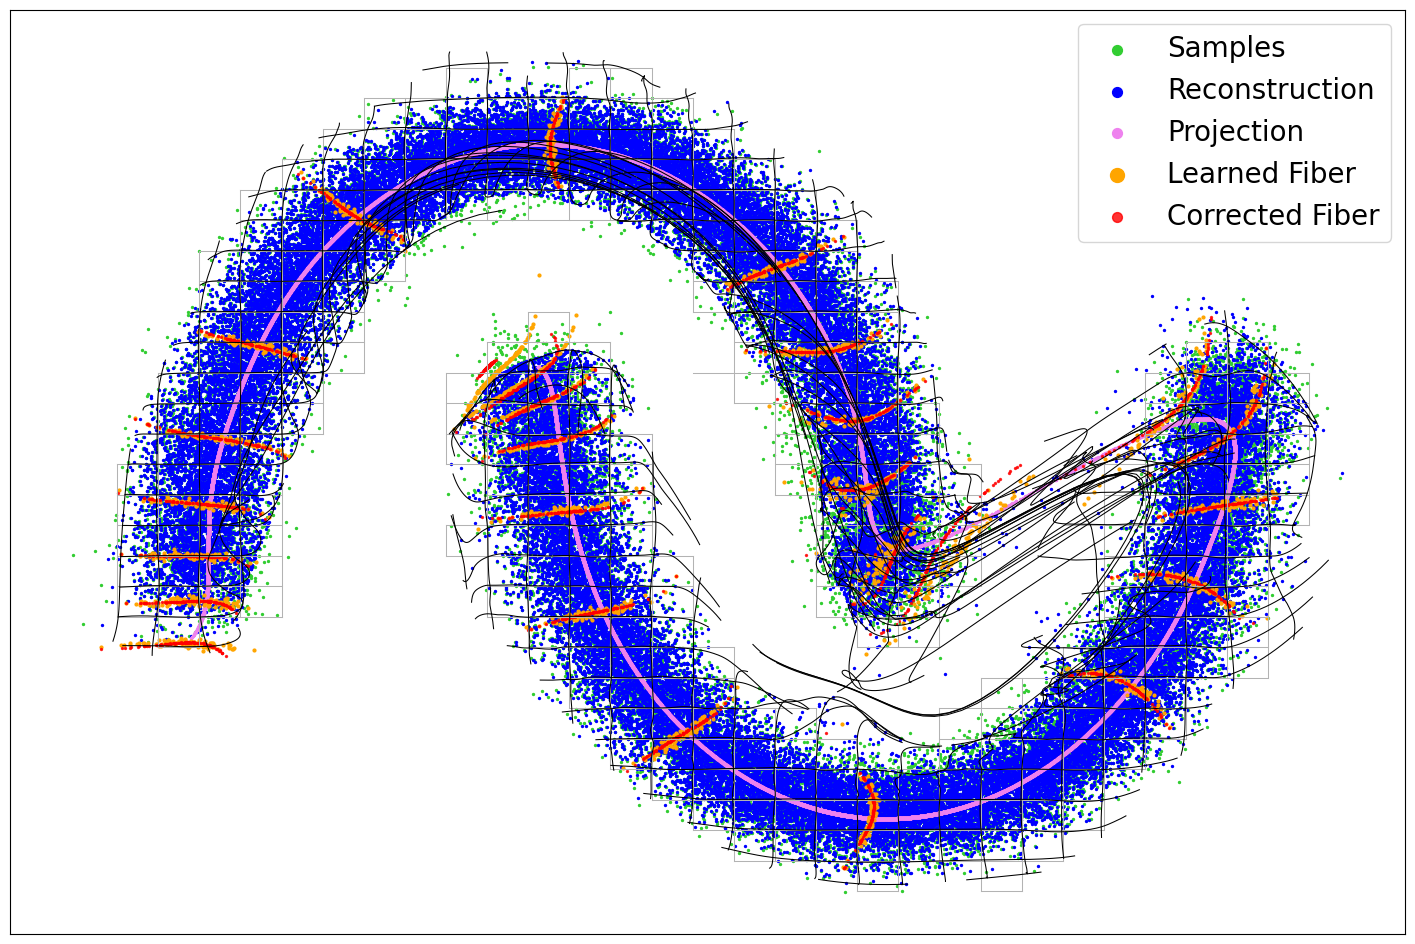

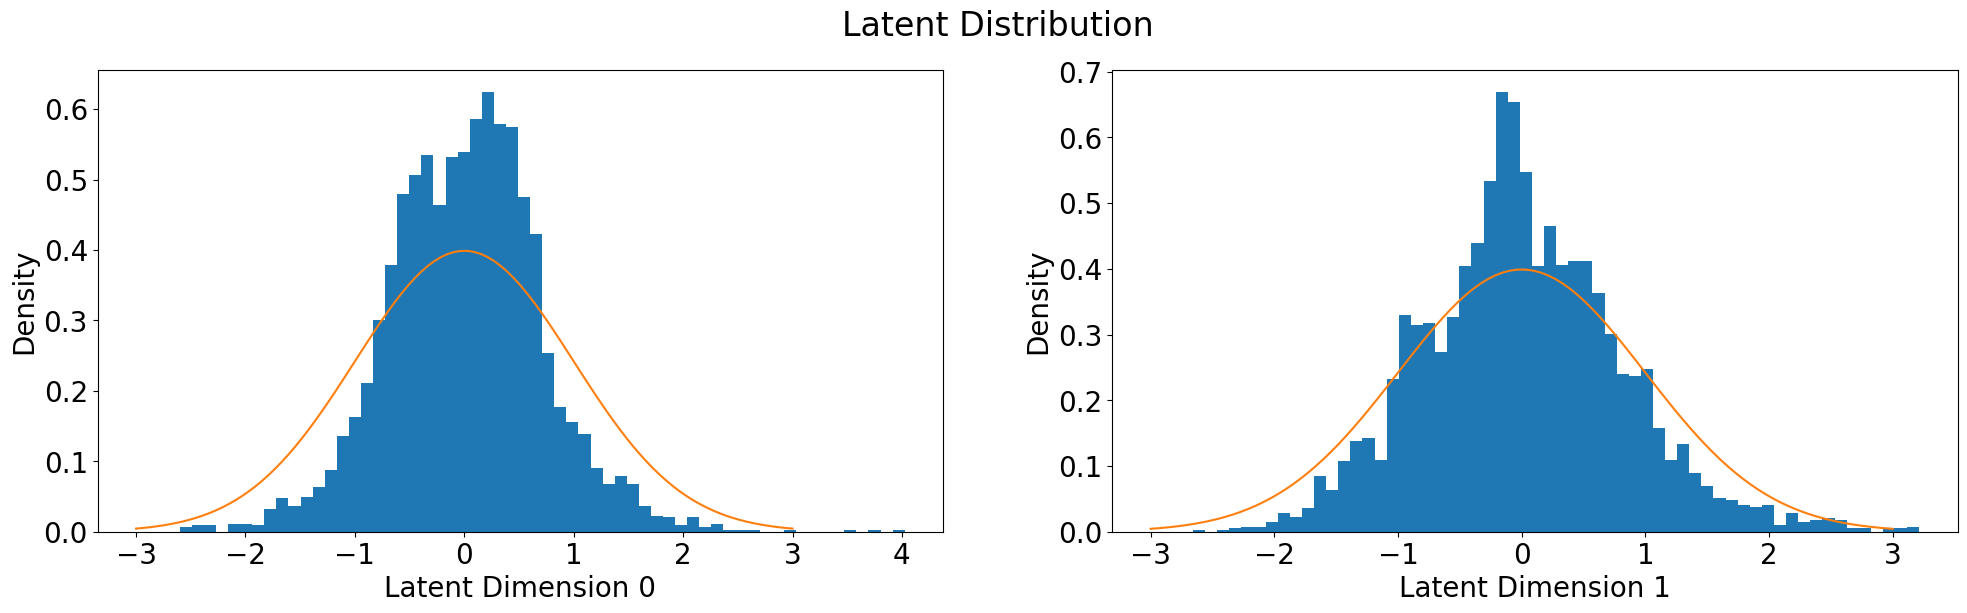

In [271]:
c_targets = plot_GT(model, gd_steps=300, N_fibers=27)

In [269]:
from fff.evaluate.plots import all_conditions

@torch.no_grad()
def plot_GT(model, data_type='train', gd_steps=50, N_fibers=21):
    device = GT.device
    plt.figure(figsize=[18,12])
    data = {}

    if data_type=='train':
        data = GT.train_data[:]
    elif data_type=='val':
        data = GT.val_data[:]
    elif data_type=='test':
        data = GT.test_data[:]

    conditioned = GT.apply_conditions(data)
    samples = conditioned.x_noisy
    c_GT = conditioned.condition
    
    #plot samples
    plt_samples = samples.T.numpy()
    plt.scatter(*plt_samples, s=2, label=r"Samples", c='limegreen',alpha=1)

    
    print("processing data...")
    batch_size = GT.hparams.batch_size
    z_GT = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(samples.split(batch_size), c_GT.split(batch_size))
    ])
    #GT-model decodes data
    x1 = torch.cat([
        GT.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_GT.split(batch_size), c_GT.split(batch_size))
    ])
    """
    t = torch.randint(0, 1000, (z_train.size(0),), device=device).long()
    z_diff, epsilon = GT.diffuse(z_train.to(device), t, GT.alphas_.to(device))
    """
    
    #reconstruct data with model
    model.to(device)
    c_m = (z_GT - model.data_shift) / model.data_scale
    z_m = torch.cat([
        model.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(samples.split(batch_size), c_m.split(batch_size))
    ])
    x_m1 = torch.cat([
        model.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_m.split(batch_size), c_m.split(batch_size))
    ])
    recon = x_m1.cpu().T.numpy()
    #plot reconstruction
    plt.scatter(*recon, s=2, label="Reconstruction", c='b',alpha=1)
    """
    lines_x = np.array([samples[0,:],recon[0,:]])
    lines_y = np.array([samples[1,:],recon[1,:]])
    plt.plot(lines_x, lines_y, linewidth=0.4, color='red', alpha=1)
    """
    
    #plot decoded data
    plt.scatter(*x1.T, s=2, label=r"Projection", c="violet")
    
    print("sampling fibers...")
    fiber_size = 100
    step = np.concatenate((np.linspace(-3,-0.4,N_fibers//3),np.linspace(-0.3,0.3,N_fibers//3),np.linspace(0.4,3,N_fibers//3)))
    c = []
    fibers_true = []
    for i in range(N_fibers):
        c.append(((torch.ones([fiber_size,1]) * step[i]) - model.data_shift) / model.data_scale)
    c = torch.cat(c)
    fibers_learned = model.sample(torch.Size([N_fibers*fiber_size]), c.to(device)).cpu()
    #correct fibers
    for i in range(N_fibers):
        x_c, _ = calc_PGD(fibers_learned[i*fiber_size:(i+1)*fiber_size], c[i*fiber_size:(i+1)*fiber_size], gd_steps)
        fibers_true.append(x_c)
    fibers_true = torch.cat(fibers_true)
    #plot both fibers
    plt.scatter(*fibers_learned.T, s=4, color = "orange", label="Learned Fiber")
    plt.scatter(*fibers_true.T, s=2, color = "red", label="Corrected Fiber",alpha=0.8)

    #plot grid reconstruction
    plot_samples_grid(plt, model)

    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    plt.legend(markerscale=5.)
    plt.show()
    plt.close()

    
    #plot latent distribution
    n_dim = z_m.shape[1]
    fig, axes = plt.subplots(1, n_dim, figsize=(24, 6))
    a = np.linspace(-3,3,100)
    for i in range(n_dim):
        axes[i].hist(z_m[:4000,i].squeeze(), bins=60, density=True)
        axes[i].plot(a, normal(a))
        axes[i].set_xlabel(f'Latent Dimension {i}')
        axes[i].set_ylabel('Density')
    fig.suptitle(f'Latent Distribution')

In [251]:
from fff.evaluate.plots import ensure_list, build_mesh
@torch.no_grad()

def plot_grid(ax, mapping, pos_min, pos_max, resolution=25,
              sub_resolution=0, color="black", linewidth=0.75, linestyle="-",
              pos_in_filter=None, device=None, dtype=None, **kwargs):
    for row_mode, this_resolution in zip([True, False],
                                         ensure_list(resolution, 2)):
        lines_resolution = [this_resolution,
                            this_resolution * (sub_resolution + 1)][::-1 if row_mode else 1]
        x, y, pos = build_mesh(pos_min, pos_max, lines_resolution,
                               device=device, dtype=dtype)
        if pos_in_filter is not None:
            pos[~pos_in_filter(pos)] = float("nan")
        pos_out = mapping(pos).cpu()
        pos_new = pos_out.reshape((*x.shape, -1)).numpy()
        if row_mode:
            segs = pos_new.transpose(1, 0, 2)
        else:
            segs = pos_new
        ax.plot(segs[:, :, 0], segs[:, :, 1], ls=linestyle, color=color,
                 lw=linewidth, **kwargs)

@torch.no_grad()
def plot_samples_grid(ax, model, resolution=30):
    extent = [-2, 2]
    def reconstruction(x):
        x = x.to(GT.device)
        print(x.shape)
        c_GT = GT.apply_conditions((x,)).condition
        c = (GT.encode(x, c_GT) - model.data_shift) / model.data_scale
        return model(x,c)
    
    def distance_filter(pos):
        dist = torch.min(((pos.unsqueeze(0) - model.val_data[:][0].unsqueeze(1))**2).sum(dim=2), dim=0)[0]
        return dist < 0.035
    
    plot_grid(ax, lambda x: x, *extent, color="0.7", resolution=resolution, pos_in_filter=distance_filter)
    plot_grid(ax, reconstruction, *extent, sub_resolution=50, resolution=resolution, pos_in_filter=distance_filter)

torch.Size([45900, 2])
torch.Size([45900, 2])


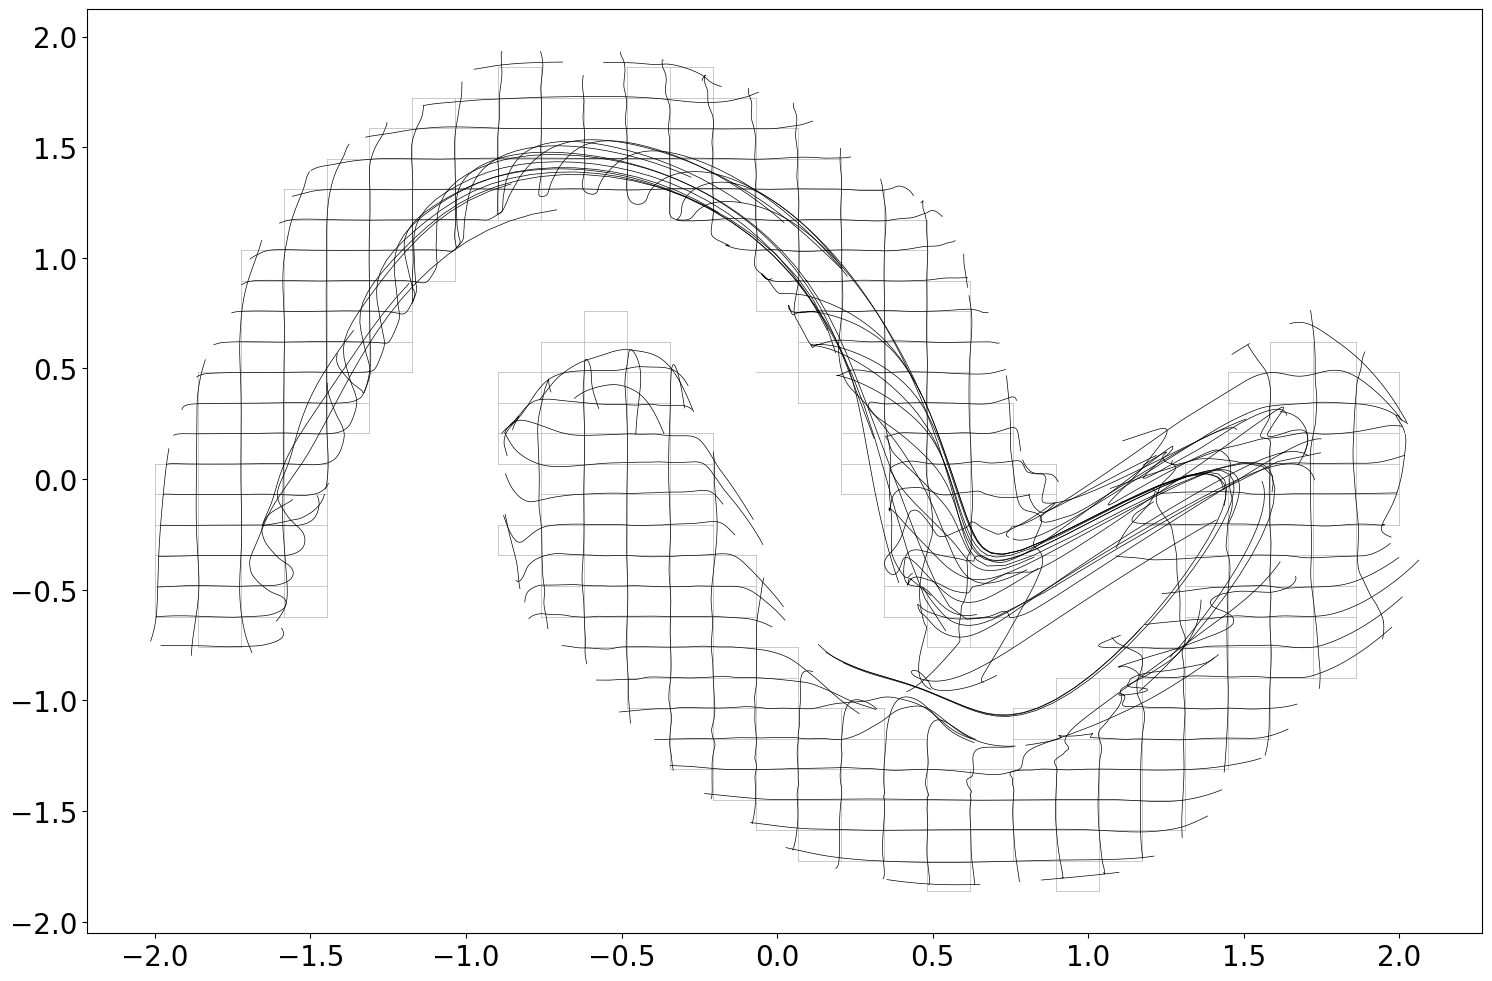

In [249]:
fig, axes = plt.subplots(1, 1, figsize=(18, 12))

plot_samples_grid(axes, model)

In [7]:
def calc_PGD(x, c0, n_steps):
    torch.set_grad_enabled(True)
    c0 = torch.unsqueeze(c0,dim=0)
    x = x.to(model.device)
    
    def closs(c0, c_hat, x_hat):
        v = torch.sum(torch.sqrt(torch.sum(((c0 - c_hat)**2), dim=-1)))
        #distance = torch.sqrt(torch.sum(((x_hat.detach().cpu() - vx[0])**2), dim=-1))
        #r = torch.max(torch.Tensor([0., (distance - constraint).item()]))
        #print("loss:", v.item())
        #if r != 0:
        #    print("penalty:", r.item())
        return v
    
    class XModel(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.param = torch.nn.Parameter(x.clone())
    
    xmodel = XModel()
    optimizer = torch.optim.SGD(xmodel.parameters(), lr=0.001)
    max_x = torch.max(torch.abs(xmodel.param))
    
    c_empty = torch.empty((0,), device=model.device, dtype=x.dtype)
    for i in range(n_steps):
        conditioned = GT.apply_conditions((xmodel.param.to(model.device),))
        c_GT = conditioned.condition
        x_GT = conditioned.x0
        xc = (GT.encode(x_GT, c_GT).cpu() - model.data_shift) / model.data_scale
        loss = closs(c0, xc, x)
        loss.backward()
        optimizer.step()
        # check, if image gets further apart than 
        #check = torch.mean(torch.sqrt(torch.sum(((x0 - zx.cpu())**2), dim=-1)))
        #if check > constraint:
        #    print("too far:")
        #    print(check.item())
        optimizer.zero_grad()

    
    
    torch.set_grad_enabled(False)
    max_x_after = torch.max(torch.abs(xmodel.param))
    if max_x_after > 5. and (max_x_after-max_x) > 1.:
        print("warning!, z got an extreme value:", max_x_after)
    #zx = model.decode(xmodel.param.to(model.device), c_empty).detach().cpu()
    x = xmodel.param.detach().cpu()
    print(loss.item())
    return x, loss

In [15]:
c = c_targets[2].squeeze()
print(torch.min(c).item())
print(torch.max(c).item())

TypeError: 'NoneType' object is not subscriptable

In [14]:
from fff.evaluate.plots import all_conditions
def plot_cond_manifold(rectangular_flow):
    eps = 1e-12
    plt.figure(figsize=[18,12])

    train_batch = rectangular_flow.train_data[:]
    val_batch = rectangular_flow.test_data[:5000]

    conditioned = rectangular_flow.apply_conditions(train_batch)
    train_samples = conditioned.x_noisy
    c_train = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_batch)
    val_samples = conditioned.x_noisy
    c = conditioned.condition

    device = rectangular_flow.device
    print("encoding...")
    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c.split(batch_size))
    ])
    print("decoding...")
    x1_train = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_train.split(batch_size), c.split(batch_size))
    ])
    z_test = torch.randn_like(z_train)
    print("decoding...")
    x1_test = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_test.split(batch_size), c.split(batch_size))
    ])
    print(x1_test.shape)

    plt.scatter(*val_samples.T, s=1, label="Original")
    plt.scatter(*x1_train.T, s=1, label="Reconstruction")
    plt.scatter(*x1_test.T, s=1, label="Samples")
    fibres, conditions = sample_fibres(rectangular_flow)
    print(fibres.shape)

    c_targets = []

    for i in range(conditions.shape[0]):
        r = 0.0005
        x1 = torch.Tensor([0])
        while x1.shape[0]<20 and r<0.01:
            mask1 = np.squeeze(c_train>conditions[i]-r)
            mask2 = np.squeeze(c_train<conditions[i]+r)
            mask = torch.logical_and(mask1, mask2)
            c_target=c_train[mask]
            x1 = train_samples[mask]
            r = r*1.1
            
        print(x1.shape[0])
        c_targets.append(c_target)
        plt.scatter(
                            x1[:,0],
                            x1[:,1],
                            s = 2,
                            c = "black",
                        )
    plt.scatter(
                [100],
                [100],
                s = 1,
                c = "black",
                label = "OrigFib",
                )

    plt.scatter(*fibres.T, s=1, c='red', label="Fibres")

    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.legend(markerscale=5.)
    plt.savefig("fib_2m_small")
    plt.show()
    plt.close()

    plt.hist(*z_train.T, bins=60, label="Samples")
    plt.show()

    return c_targets

In [5]:
def sample_fibres(model, sub_resolution=100):
    samples = []
    pos_min, pos_max = -2.0, 2.0
    resolution = 50
    conditions = torch.linspace(pos_min, pos_max, resolution, device=model.device)
    latents = torch.randn([sub_resolution,1], device=model.device)
    for c in conditions:
        cond = c.repeat(latents.shape[0],1)
        samples.append(model.decode(latents, cond))
    x = torch.cat(samples, dim=0)
    return x.cpu().detach(), conditions.cpu().numpy()

In [56]:
plot_latent_codes_2d_1d(model)

NameError: name 'plot_latent_codes_2d_1d' is not defined

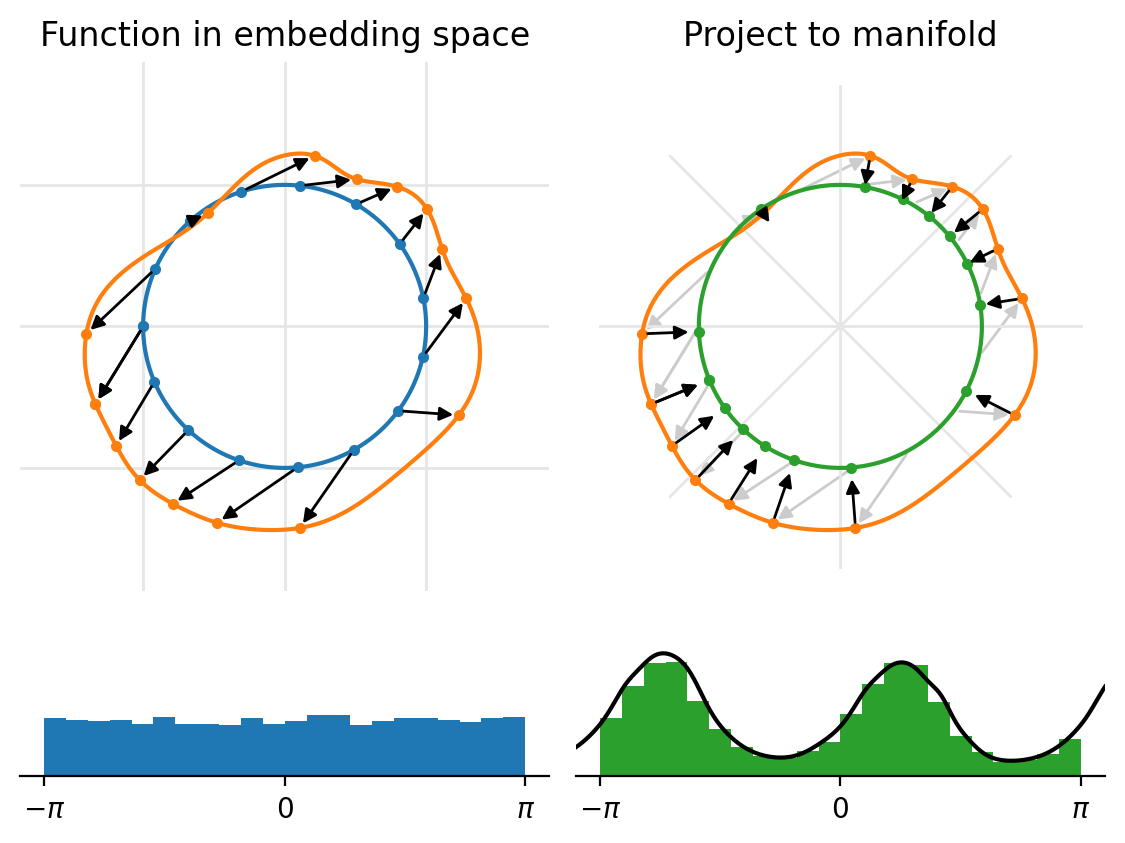

In [5]:
def euc_to_pol(x, distort=False):
    out = torch.stack([
        torch.atan2(x[:, 1], x[:, 0]),
        x.norm(2, -1)
    ], 1)
    if distort:
        # Exagerate deviations from circle
        out[:, 1] = (out[:, 1] - 1) * 3 + 1.3
    return out


def pol_to_euc(x):
    return x[:, 1:] * torch.stack([
        torch.cos(x[:, 0]),
        torch.sin(x[:, 0])
    ], 1)


fig, axes = plt.subplots(2, 2, sharex="row", sharey="row", figsize=(7, 5),
                         gridspec_kw=dict(height_ratios=[1, .2]))

# Generation process from equally spaced points in latent space
thetas_fine = torch.linspace(-torch.pi, torch.pi, 360)
z_fine = torch.stack([
    torch.cos(thetas_fine),
    torch.sin(thetas_fine)
], 1)
batch = model.apply_conditions([z_fine])
x1_fine = model.decode(batch.x0, batch.condition, project=False)
x1_proj_fine = model.manifold.projection(x1_fine)
x1_distorted_fine = pol_to_euc(euc_to_pol(x1_fine, True))
pol1_proj_fine = euc_to_pol(x1_proj_fine)

# Neural network acts in embedding
plt.sca(axes[0, 0])
plt.plot(*z_fine.T, label="Input data")
plt.plot(*x1_distorted_fine.T, label="Raw output")
subset = torch.linspace(0, len(thetas_fine) - 1, 16).long()
ms = 3
plt.plot(*z_fine[subset].T, "C0o", label="Selected raw output", ms=ms)
plt.plot(*x1_distorted_fine[subset].T, "C1o", label="Selected raw output", ms=ms)
for x_in, x_out in zip(z_fine[subset], x1_distorted_fine[subset]):
    plt.annotate("", x_out, x_in, arrowprops=dict(
        arrowstyle='-|>', fc="k",
    ))
plt.axis("off")
plt.title("Function in embedding space")
axes[0, 0].set_aspect(1)
for pos in [-1, 0, 1]:
    plt.axhline(pos, c=".9", zorder=-1, lw=1)
    plt.axvline(pos, c=".9", zorder=-1, lw=1)


# Projection to circle
plt.sca(axes[0, 1])
plt.title("Project to manifold")
plt.plot(*x1_distorted_fine.T, "C1", label="Raw output")
plt.plot(*x1_proj_fine.T, "C2", label="Projected output")
plt.plot(*x1_distorted_fine[subset].T, "C1o", label="Selected raw output", ms=ms)
plt.plot(*x1_proj_fine[subset].T, "C2o", label="Selected raw output", ms=ms)
for x0, x_in, x_out in zip(
    z_fine[subset], x1_distorted_fine[subset], x1_fine[subset]
):
    plt.annotate("", x_in, x0, arrowprops=dict(
        arrowstyle='-|>', fc=".8", ec=".8"
    ), zorder=-1)
    plt.annotate("", x_out, x_in, arrowprops=dict(
        arrowstyle='-|>', fc="k",
    ))
# Hint at polar projection using fake grid
for theta in torch.linspace(0, 2 * torch.pi, 8 + 1)[:-1]:
    plt.plot([0, 1.7 * np.cos(theta)], [0, 1.7 * np.sin(theta)], c=".9", zorder=-1, lw=1)

plt.axis("off")
axes[0, 1].set_aspect(1)

# Lower plots: Show histograms
count = 10_000
for ax, samples, color in zip(axes[1], [
    model.get_latent("cpu").sample((count,)),
    model.sample((count,)),
], ["C0", "C2"]):
    plt.sca(ax)
    ax.spines[["left", "top", "right"]].set_visible(False)
    plt.hist(euc_to_pol(samples)[:, 0], "auto", density=True, fc=color)
    plt.yticks([])
    plt.xticks([-np.pi, 0, np.pi], ["$-\\pi$", "$0$", "$\\pi$"])
    plt.xlim(-1.1 * np.pi, 1.1 * np.pi)

# Show density in lower left plot
plt.sca(axes[1, 1])
thetas_fine = torch.linspace(-1.1 * torch.pi, 1.1 * torch.pi, 300)
z_fine = torch.stack([
    torch.cos(thetas_fine),
    torch.sin(thetas_fine)
], 1)
batch = model.apply_conditions([z_fine])
probs = model.exact_log_prob(batch.x0, batch.condition).log_prob.exp()
plt.plot(thetas_fine, probs, "k")

# Adjust spacing
plt.subplots_adjust(wspace=.05, hspace=0)
# plt.savefig("m-fff-projection.pdf", bbox_inches="tight")

In [ ]:
train_data = GT.train_data[:]
    val_data = GT.val_data[:]
    test_data = GT.test_data[:]

    conditioned = GT.apply_conditions(train_data)
    train_samples = conditioned.x_noisy
    c_t = conditioned.condition
    
    conditioned = GT.apply_conditions(val_data)
    val_samples = conditioned.x_noisy
    c_v = conditioned.condition

    conditioned = GT.apply_conditions(test_data)
    test_samples = conditioned.x_noisy
    c_test = conditioned.condition
    
    print("encoding traindata...")
    batch_size = GT.hparams.batch_size
    z_train = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])
    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train.cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val.cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test.cpu().numpy()